<!--<img src="" alt="drawing" style="width:400px;"/> -->
<h1 style="text-align: center;"><a title="Data Science-AIMS-Cmr-2021-22"> Recurrent Neural Networks for Sequential Data Modeling </h1>
<!--<img src="" alt="drawing" style="width:400px;"/> -->

## Instructors:

* Dr Bubacarr Bah

* Rockefeller

In [ ]:
import numpy as np
np.random.seed(123)

import matplotlib.pyplot as plt
import pandas as pd
import math

import tensorflow as tf
#tf.set_random_seed(1234)

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, SimpleRNN
from sklearn.metrics import mean_squared_error

%matplotlib inline

Let's start by print out the versions of the libraries we're using for future reference

# Create dataset

For simplicity sake, let's assume this is your dataset. If you understand how the partition works in 1D (univariate case), scaling it to multivariate case will use the same logic.

In [ ]:
my_ts = np.arange(20)
my_ts

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [ ]:
fake_values = pd.DataFrame(my_ts)

fake_df = pd.concat([fake_values.shift(2), fake_values.shift(1), fake_values.shift(0)], axis=1)
fake_df.columns = ['t-2', 't-1', 't']
fake_df = fake_df.dropna(how= 'any')
fake_df

,t-2,t-1,t
2,0.0,1.0,2
3,1.0,2.0,3
4,2.0,3.0,4
5,3.0,4.0,5
6,4.0,5.0,6
7,5.0,6.0,7
8,6.0,7.0,8
9,7.0,8.0,9
10,8.0,9.0,10
11,9.0,10.0,11


In [ ]:
def partition_data(your_ts, look_back):
  data_frame  =pd.DataFrame(your_ts)
  stretched_data =pd.concat([data_frame.shift(i) for i in reversed(range(look_back+1))], axis=1)
  stretched_data = stretched_data.dropna(how= 'any')
  col_names = ['t-'+str(ind_) for ind_ in reversed(range(look_back+1))]
  col_names[-1] = 't'
  stretched_data.columns  = col_names
  return stretched_data

In [ ]:
df_new =   partition_data(my_ts, 4)
df_new

,t-4,t-3,t-2,t-1,t
4,0.0,1.0,2.0,3.0,4
5,1.0,2.0,3.0,4.0,5
6,2.0,3.0,4.0,5.0,6
7,3.0,4.0,5.0,6.0,7
8,4.0,5.0,6.0,7.0,8
9,5.0,6.0,7.0,8.0,9
10,6.0,7.0,8.0,9.0,10
11,7.0,8.0,9.0,10.0,11
12,8.0,9.0,10.0,11.0,12
13,9.0,10.0,11.0,12.0,13


In [ ]:
def data_windowing(data_series,window_size):
    """before you use this function, rearrange your data under the format (samples, features)"""
    x = []
    y = []
    L = len(data_series)

    for i in range(L-window_size):
        window = data_series[i:i+window_size]
        label = data_series[i+window_size:i+window_size+1]
        x.append(window)
        y.append(label)

    return np.array(x),np.array(y)

In [ ]:
my_ts =  my_ts.reshape(10,2)
my_ts

array([[ 0,  1],
       [ 2,  3],
       [ 4,  5],
       [ 6,  7],
       [ 8,  9],
       [10, 11],
       [12, 13],
       [14, 15],
       [16, 17],
       [18, 19]])

In [ ]:
X , y = data_windowing(my_ts, 4)

In [ ]:
X

array([[[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7]],

       [[ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9]],

       [[ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11]],

       [[ 6,  7],
        [ 8,  9],
        [10, 11],
        [12, 13]],

       [[ 8,  9],
        [10, 11],
        [12, 13],
        [14, 15]],

       [[10, 11],
        [12, 13],
        [14, 15],
        [16, 17]]])

In [ ]:
y

array([[[ 8,  9]],

       [[10, 11]],

       [[12, 13]],

       [[14, 15]],

       [[16, 17]],

       [[18, 19]]])

In [ ]:
print("the input shape" , X.shape )
print("the output shape" , y.shape)

the input shape (6, 4, 2)
the output shape (6, 1, 2)


Let's use some real data to fit our first RNN Model

In [ ]:
X = np.arange(0, 360)
y = np.sin(X*np.pi/10)
df = pd.DataFrame({"X": X, "y":y})
df

,X,y
0,0,0.000000
1,1,0.309017
2,2,0.587785
3,3,0.809017
4,4,0.951057
...,...,...
355,355,-1.000000
356,356,-0.951057
357,357,-0.809017
358,358,-0.587785


It's always important to see what you are doing. You can save a lot of time like this ;)

Text(0, 0.5, 'y')

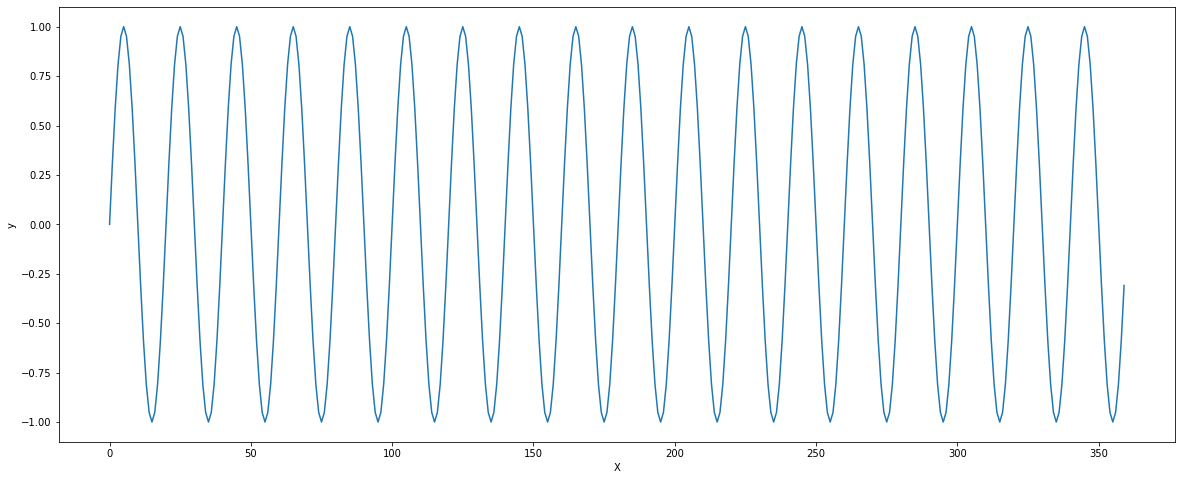

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(df.y)
plt.xlabel('X')
plt.ylabel('y')

## Training and Testing datasets
The y values are just the next x value.
Let's use 1 time step in to predict the next value of the series.

In [ ]:
sinValues=df['y']

In [ ]:
df_new =   partition_data(sinValues, 1)
df_new

,t-1,t
1,0.000000,0.309017
2,0.309017,0.587785
3,0.587785,0.809017
4,0.809017,0.951057
5,0.951057,1.000000
...,...,...
355,-0.951057,-1.000000
356,-1.000000,-0.951057
357,-0.951057,-0.809017
358,-0.809017,-0.587785


We'll be using the first 2/3 of the timeseries to train the model and the last 1/3 to evaluate it.

In [ ]:
X , y = data_windowing(sinValues.values, 1)
n_points = len(X)
train_points = int(2/3*n_points)+1
X_train, X_test = X[:train_points] , X[train_points:]
y_train, y_test = y[:train_points] , y[train_points:]

In [ ]:
print("We have", len(X_train), "training points and", X_test.shape[0], "testing points")

We have 240 training points and 119 testing points


In [ ]:
print(X_train.shape)
print(X_test.shape)

(240, 1)
(119, 1)


In [ ]:
X_train

array([[ 0.00000000e+00],
       [ 3.09016994e-01],
       [ 5.87785252e-01],
       [ 8.09016994e-01],
       [ 9.51056516e-01],
       [ 1.00000000e+00],
       [ 9.51056516e-01],
       [ 8.09016994e-01],
       [ 5.87785252e-01],
       [ 3.09016994e-01],
       [ 1.22464680e-16],
       [-3.09016994e-01],
       [-5.87785252e-01],
       [-8.09016994e-01],
       [-9.51056516e-01],
       [-1.00000000e+00],
       [-9.51056516e-01],
       [-8.09016994e-01],
       [-5.87785252e-01],
       [-3.09016994e-01],
       [-2.44929360e-16],
       [ 3.09016994e-01],
       [ 5.87785252e-01],
       [ 8.09016994e-01],
       [ 9.51056516e-01],
       [ 1.00000000e+00],
       [ 9.51056516e-01],
       [ 8.09016994e-01],
       [ 5.87785252e-01],
       [ 3.09016994e-01],
       [ 3.67394040e-16],
       [-3.09016994e-01],
       [-5.87785252e-01],
       [-8.09016994e-01],
       [-9.51056516e-01],
       [-1.00000000e+00],
       [-9.51056516e-01],
       [-8.09016994e-01],
       [-5.8

The SimpleRNN model expects a 3D ([samples, time steps, features]) dataset so we reshape them accordingly

In [ ]:
from tensorflow.python.framework import ops
ops.reset_default_graph()
keras.backend.clear_session()


We're only using one timestep

## Define the model architecture.
We'll be using a SimpleRNN model with 10 hidden units. The Dense layer at the end has a linear activation function to aggregate the outputs of all the hidden units.

In [ ]:
# TO UNDERSTAND THE STRUCTURE OF A RNN Cell
hidden_units  = 3
dense_units = 2
input_shape = (3,2)
toy_model = Sequential()
toy_model.add(SimpleRNN(hidden_units, input_shape=input_shape,  activation='tanh' ))#, use_bias= False)) #transition equation
toy_model.add(Dense(units=dense_units, activation= 'linear'))#, use_bias= False)) #output equation
toy_model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
toy_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 3)                 18        
                                                                 
 dense (Dense)               (None, 2)                 8         
                                                                 
Total params: 26
Trainable params: 26
Non-trainable params: 0
_________________________________________________________________


In [ ]:
X_train.shape

(240, 1)

In [ ]:
model = Sequential()
model.add(SimpleRNN(units=5, input_shape=(X_train.shape[0], X_train.shape[1]))) #input_shape takes time steps and features
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='sgd')

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 5)                 35        
                                                                 
 dense_1 (Dense)             (None, 1)                 6         
                                                                 
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


## Train the model

In [ ]:
nb_epoch = 30

model.fit(X_train, y_train, epochs=nb_epoch)

Epoch 1/30


8/8 [==============================] - 4s 5ms/step - loss: 0.3364
Epoch 2/30
8/8 [==============================] - 0s 4ms/step - loss: 0.2395
Epoch 3/30
8/8 [==============================] - 0s 4ms/step - loss: 0.1759
Epoch 4/30
8/8 [==============================] - 0s 4ms/step - loss: 0.1326
Epoch 5/30
8/8 [==============================] - 0s 4ms/step - loss: 0.1036
Epoch 6/30
8/8 [==============================] - 0s 4ms/step - loss: 0.0841
Epoch 7/30
8/8 [==============================] - 0s 4ms/step - loss: 0.0718
Epoch 8/30
8/8 [==============================] - 0s 4ms/step - loss: 0.0635
Epoch 9/30
8/8 [==============================] - 0s 4ms/step - loss: 0.0581
Epoch 10/30
8/8 [==============================] - 0s 4ms/step - loss: 0.0548
Epoch 11/30
8/8 [==============================] - 0s 3ms/step - loss: 0.0526
Epoch 12/30
8/8 [==============================] - 0s 4ms/step - loss: 0.0512
Epoch 13/30
8/8 [==============================] - 0s 4ms/step - loss: 0.0503
Epoch 

## Make predictions

In [ ]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

4/4 [==============================] - 0s 3ms/step


In [ ]:
mean_squared_error(y_train_pred , y_train)

0.04836389927796092

Compile the values

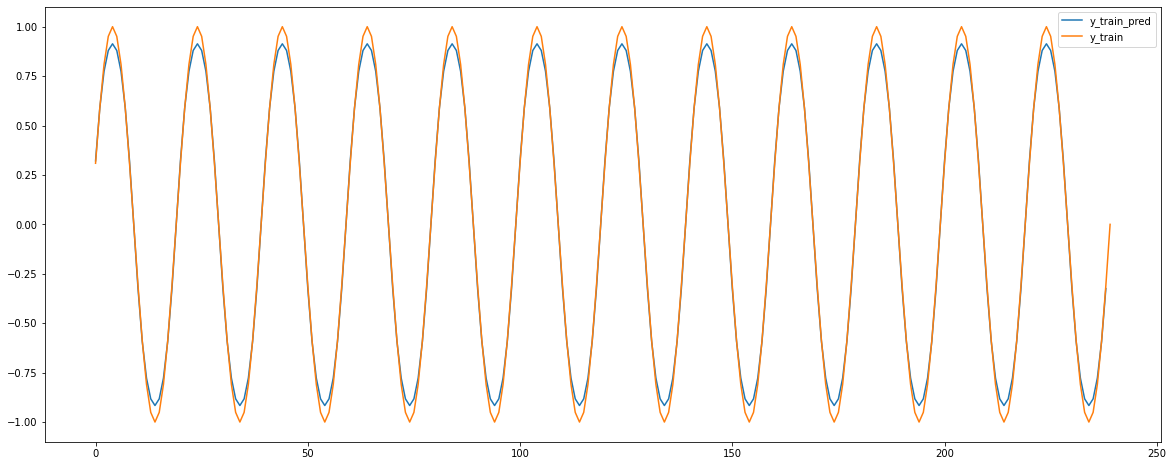

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(y_train_pred[1:] , label ='y_train_pred')
plt.plot(y_train , label ='y_train')
plt.legend(loc='upper right')


In [ ]:
mean_squared_error(y_test_pred , y_test)

0.047883288163550405

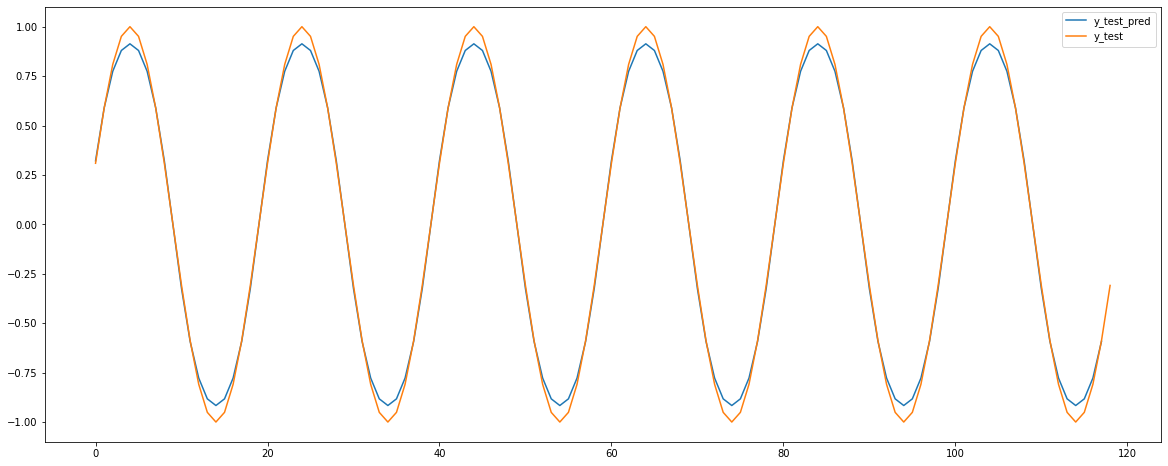

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(y_test_pred[1:],label ='y_test_pred' )
plt.plot(y_test , label ='y_test')
plt.legend(loc='best')


# LSTM
Let's now try using a slightly more sophisticated architecture

In [ ]:
model = Sequential()
model.add(LSTM(4, input_shape=(X_train.shape[0], X_train.shape[1]))) #input_shape takes time steps and features
#model.add(LSTM(10))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4)                 96        
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [ ]:
nb_epoch = 50

model.fit(X_train, y_train, epochs=nb_epoch)

Epoch 1/50


8/8 [==============================] - 3s 5ms/step - loss: 0.6314
Epoch 2/50
8/8 [==============================] - 0s 4ms/step - loss: 0.6242
Epoch 3/50
8/8 [==============================] - 0s 4ms/step - loss: 0.6171
Epoch 4/50
8/8 [==============================] - 0s 4ms/step - loss: 0.6107
Epoch 5/50
8/8 [==============================] - 0s 4ms/step - loss: 0.6042
Epoch 6/50
8/8 [==============================] - 0s 5ms/step - loss: 0.5984
Epoch 7/50
8/8 [==============================] - 0s 6ms/step - loss: 0.5926
Epoch 8/50
8/8 [==============================] - 0s 4ms/step - loss: 0.5870
Epoch 9/50
8/8 [==============================] - 0s 4ms/step - loss: 0.5819
Epoch 10/50
8/8 [==============================] - 0s 4ms/step - loss: 0.5765
Epoch 11/50
8/8 [==============================] - 0s 4ms/step - loss: 0.5715
Epoch 12/50
8/8 [==============================] - 0s 4ms/step - loss: 0.5662
Epoch 13/50
8/8 [==============================] - 0s 4ms/step - loss: 0.5612
Epoch 

Calculate the predicted values

In [ ]:
y_train_pred_LSTM = model.predict(X_train)
y_test_pred_LSTM = model.predict(X_test)


4/4 [==============================] - 0s 3ms/step


In [ ]:
mean_squared_error(y_train_pred_LSTM , y_train)

0.30418872327497265

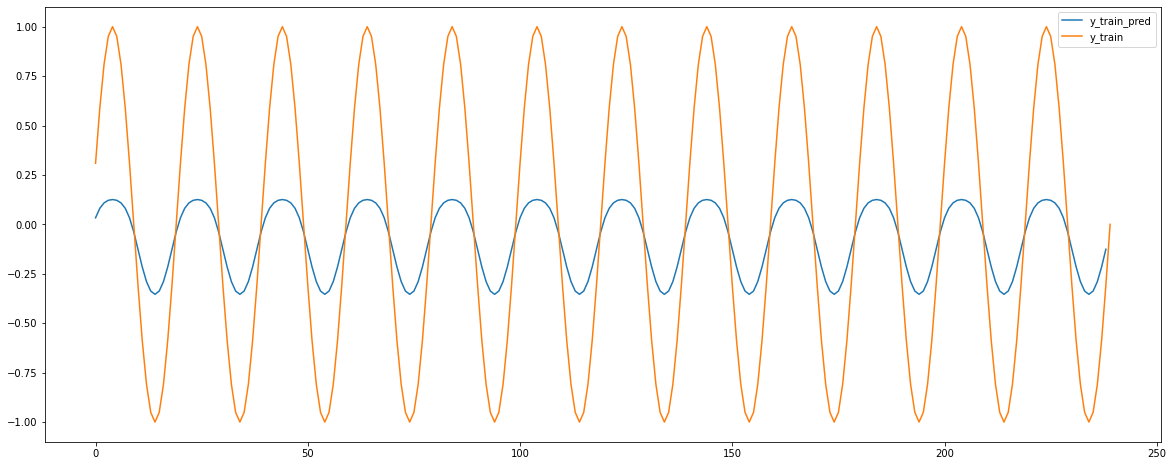

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(y_train_pred_LSTM[1:] , label ='y_train_pred')
plt.plot(y_train , label ='y_train')
plt.legend(loc='upper right')


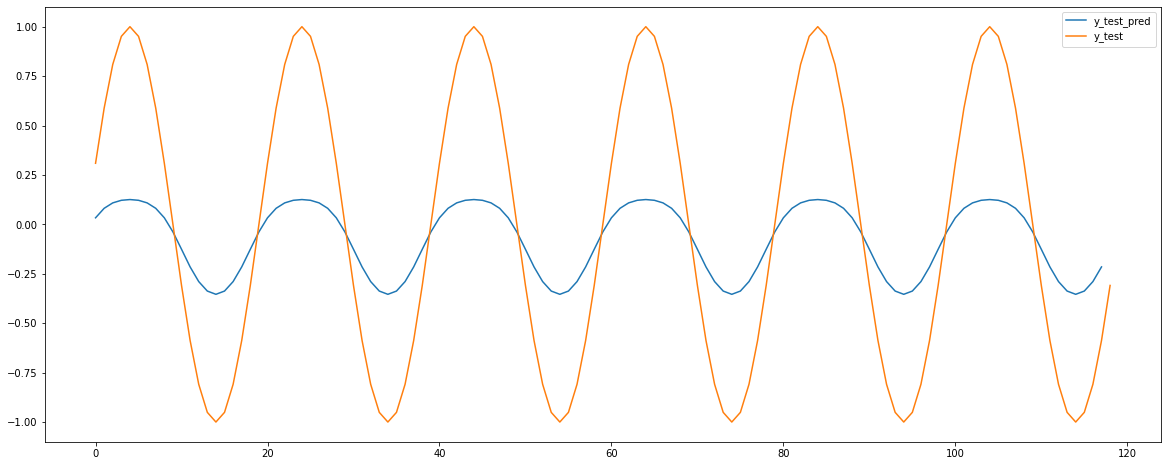

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(y_test_pred_LSTM[1:],label ='y_test_pred' )
plt.plot(y_test , label ='y_test')
plt.legend(loc='best')


# Multiple timesteps
So far we've been using architectures with just a single timestep. Now we'll see how we can use multiple timesteps (t-1, t) to predict the value at t+1. We'll keep the basic architecture of the system. We still have the raw data in memory, so we don't need to reload it. We just have to be careful when we build the inputs

In [ ]:
sinValues = pd.DataFrame(df.y.values)

df_new = pd.concat([sinValues.shift(3),sinValues.shift(2) , sinValues.shift(1), sinValues], axis=1)
df_new.columns = ['t-3', 't-2' , 't-1' , 't']
df_new = df_new.dropna(how= 'any')
df_new.head(5)

,t-3,t-2,t-1,t
3,0.000000,0.309017,0.587785,0.809017
4,0.309017,0.587785,0.809017,0.951057
5,0.587785,0.809017,0.951057,1.000000
6,0.809017,0.951057,1.000000,0.951057
7,0.951057,1.000000,0.951057,0.809017


In [ ]:
X , y = data_windowing(sinValues.values, 3)
n_points = len(X)
train_points = int(2/3*n_points)+1
X2_train, X2_test = X[:train_points] , X[train_points:]
y2_train, y2_test = y[:train_points] , y[train_points:]

In [ ]:

print("We have", len(X_train), "training points and", X_test.shape[0], "testing points")

We have 240 training points and 119 testing points


The more we increas the lag, the more points we lose! The rest of the code looks pretty much the same

In [ ]:

print(X2_train.shape)
print(X2_test.shape)

(239, 3, 1)
(118, 3, 1)


But now we see that the result is slightly different. For each of our examples, we now have 3 timesteps to consider. Now we just need to refine the model:

In [ ]:
model = Sequential()
model.add(LSTM(units=10, input_shape=(X2_train.shape[1], X2_train.shape[2]))) #input_shape takes time steps and features
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 10)                480       
                                                                 
 dense_4 (Dense)             (None, 1)                 11        
                                                                 
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


In [ ]:
nb_epoch = 50
model.fit(X2_train, y2_train, epochs=nb_epoch, shuffle=False)

Epoch 1/50
8/8 [==============================] - 2s 4ms/step - loss: 0.6571
Epoch 2/50
8/8 [==============================] - 0s 4ms/step - loss: 0.6267
Epoch 3/50
8/8 [==============================] - 0s 4ms/step - loss: 0.5986
Epoch 4/50
8/8 [==============================] - 0s 4ms/step - loss: 0.5722
Epoch 5/50
8/8 [==============================] - 0s 5ms/step - loss: 0.5475
Epoch 6/50
8/8 [==============================] - 0s 4ms/step - loss: 0.5241
Epoch 7/50
8/8 [==============================] - 0s 5ms/step - loss: 0.5017
Epoch 8/50
8/8 [==============================] - 0s 4ms/step - loss: 0.4800
Epoch 9/50
8/8 [==============================] - 0s 4ms/step - loss: 0.4589
Epoch 10/50
8/8 [==============================] - 0s 4ms/step - loss: 0.4383
Epoch 11/50
8/8 [==============================] - 0s 4ms/step - loss: 0.4180
Epoch 12/50
8/8 [==============================] - 0s 4ms/step - loss: 0.3980
Epoch 13/50
8/8 [==============================] - 0s 4ms/step - loss: 0.

In [ ]:
y2_train_pred_LSTM = model.predict(X2_train)
y2_test_pred_LSTM = model.predict(X2_test)


4/4 [==============================] - 0s 3ms/step


In [ ]:
y2_train[:,0,0].shape


(239,)

In [ ]:
mean_squared_error(y2_train_pred_LSTM [:,0], y2_train[:,0,0])

0.14930152100331137

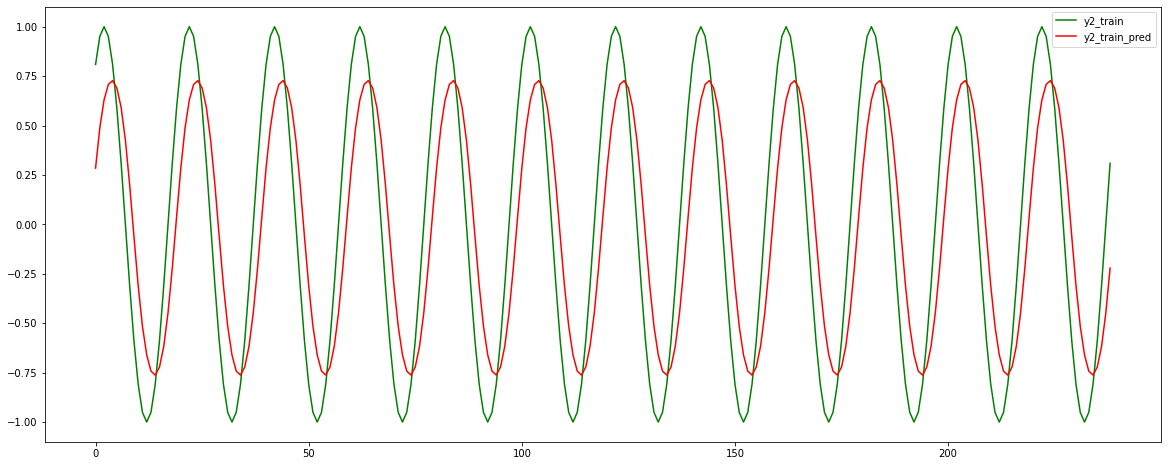

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(np.arange(len(y2_train)) , y2_train[:,0,0], label ='y2_train' , c='g')

plt.plot(np.arange(y2_train_pred_LSTM.shape[0]), y2_train_pred_LSTM[:,0], label ='y2_train_pred' , c='r')
plt.legend(loc='upper right')


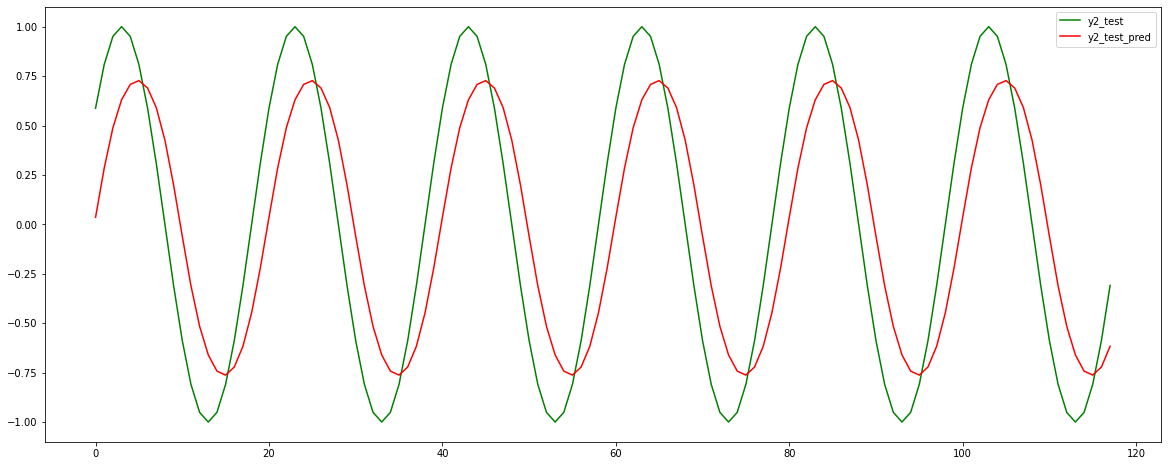

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(np.arange(len(y2_test)) , y2_test[:,0,0], label ='y2_test' , c='g')

plt.plot(np.arange(y2_test_pred_LSTM.shape[0]), y2_test_pred_LSTM[:,0], label ='y2_test_pred' , c='r')
plt.legend(loc='upper right')


# Exercice:



1.   Load the dataset from Limbe at the url adress below and design your own RNN and LSTM model.
2.   Train a Vanilla RNN model, report the characteristics of your model,  the error during training and provide a picture of your forecast.
3.   Train a LSTM model, report the characteristics of your model,  the error made during training and forecasting.

4. Provide a picture of the  forecast for both models.


5. Increase your past information and re-do step 2 and 3.


6. (Bonus) Apply a Preprocessing method of the climate product that you choose and re-do step 2 ,  3 and 4.


7. What did you learn from these experiments?



url = 'https://raw.githubusercontent.com/rock-feller/Datasets_for_Education/main/data_02/limbe_data_JanApr21.csv'

In [ ]:
url = 'https://raw.githubusercontent.com/rock-feller/Datasets_for_Education/main/data_02/limbe_data_JanApr21.csv'

In [ ]:
df4 = pd.read_csv(url, parse_dates=True)
df4

,LAT,LON,YEAR,MO,DY,WS50M_RANGE,WS10M_MIN,WS10M,WS50M,T2M_MAX,...,T2M,WS10M_RANGE,T2M_MIN,WS10M_MAX,ALLSKY_SFC_SW_DWN,T2MDEW,PS,RH2M,WS50M_MIN,WS2M
0,4.03161,9.21461,2021,1,1,3.28,0.95,1.96,2.75,29.10,...,26.50,1.54,24.93,2.49,4.46,23.99,98.45,86.04,0.89,1.40
1,4.03161,9.21461,2021,1,2,2.82,1.13,1.87,2.52,29.32,...,26.47,1.28,24.79,2.41,5.01,23.77,98.47,85.04,1.15,1.33
2,4.03161,9.21461,2021,1,3,3.02,0.61,1.62,2.17,28.16,...,26.05,1.70,24.69,2.31,4.99,23.55,98.47,86.02,0.71,1.17
3,4.03161,9.21461,2021,1,4,4.22,0.07,1.38,1.89,29.79,...,26.50,2.61,24.51,2.67,4.94,23.40,98.37,82.89,0.04,0.97
4,4.03161,9.21461,2021,1,5,3.26,0.62,1.87,2.52,28.69,...,26.24,1.87,24.60,2.50,5.17,23.85,98.33,86.60,0.77,1.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,4.03161,9.21461,2021,4,19,1.46,1.47,2.02,2.66,28.21,...,26.22,1.06,24.94,2.53,-999.00,23.98,98.41,87.46,1.98,1.42
109,4.03161,9.21461,2021,4,20,2.02,0.94,1.72,2.27,27.82,...,26.17,1.15,24.84,2.08,-999.00,23.95,98.36,87.51,1.00,1.20
110,4.03161,9.21461,2021,4,21,3.72,0.38,1.78,2.43,29.30,...,26.80,2.43,25.27,2.81,-999.00,23.90,98.35,83.97,0.52,1.28
111,4.03161,9.21461,2021,4,22,-999.00,-999.00,-999.00,-999.00,-999.00,...,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00


In [ ]:
MaxTemp = df4[df4['T2M_MAX'] >0]['T2M_MAX']

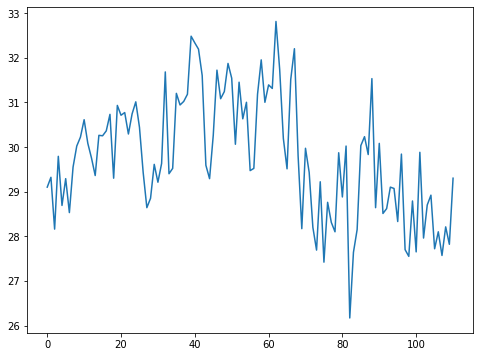

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(MaxTemp)

In [ ]:
def ReScaleAroundZero(data, a):
    data_avg = data.mean()
    scaled_data = a*(data - data_avg)
    return scaled_data

In [ ]:
MaxTemp_Rescaled  = ReScaleAroundZero(MaxTemp , 0.1)

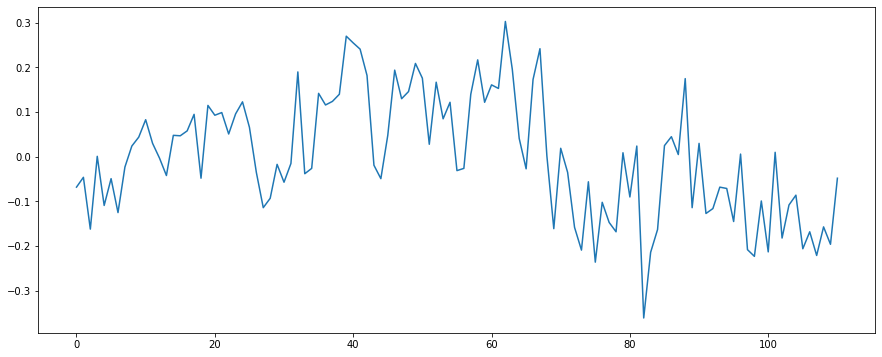

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(MaxTemp_Rescaled)

In [ ]:
MaxTempScaledValues = pd.DataFrame(MaxTemp_Rescaled)

df_new = pd.concat([MaxTempScaledValues.shift(1), MaxTempScaledValues], axis=1)
df_new.columns = ['t-1', 't']
df_new = df_new.dropna(how= 'any')
df_new.head(5)

,t-1,t
1,-0.068523,-0.046523
2,-0.046523,-0.162523
3,-0.162523,0.000477
4,0.000477,-0.109523
5,-0.109523,-0.049523


In [ ]:
n_points = len(df_new)
train_points = int(4/5*n_points)+1
X_train, X_test =df_new['t-1'].values[:train_points],  df_new['t-1'].values[train_points:  ]
y_train, y_test =df_new['t'].values[:train_points  ],  df_new['t'].values[train_points:  ]
print("We have", len(X_train), "training points and", X_test.shape[0], "testing points")

We have 89 training points and 21 testing points


In [ ]:
from tensorflow.python.framework import ops
ops.reset_default_graph()
keras.backend.clear_session()

X_train = X_train.reshape(X_train.shape[0],1, 1)
X_test = X_test.reshape(X_test.shape[0],1, 1)
print(X_train.shape)
print(X_test.shape)

(89, 1, 1)
(21, 1, 1)


In [ ]:
model = Sequential()
model.add(SimpleRNN(units=10, input_shape=(X_train.shape[1], X_train.shape[2]))) #input_shape takes time steps and features
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='sgd')

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 10)                120       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [ ]:
nb_epoch = 100

model.fit(X_train, y_train, epochs=nb_epoch)

Epoch 1/100
3/3 [==============================] - 1s 9ms/step - loss: 0.0297
Epoch 2/100
3/3 [==============================] - 0s 6ms/step - loss: 0.0290
Epoch 3/100
3/3 [==============================] - 0s 5ms/step - loss: 0.0286
Epoch 4/100
3/3 [==============================] - 0s 5ms/step - loss: 0.0282
Epoch 5/100
3/3 [==============================] - 0s 5ms/step - loss: 0.0279
Epoch 6/100
3/3 [==============================] - 0s 5ms/step - loss: 0.0278
Epoch 7/100
3/3 [==============================] - 0s 5ms/step - loss: 0.0275
Epoch 8/100
3/3 [==============================] - 0s 5ms/step - loss: 0.0274
Epoch 9/100
3/3 [==============================] - 0s 5ms/step - loss: 0.0272
Epoch 10/100
3/3 [==============================] - 0s 5ms/step - loss: 0.0271
Epoch 11/100
3/3 [==============================] - 0s 5ms/step - loss: 0.0270
Epoch 12/100
3/3 [==============================] - 0s 5ms/step - loss: 0.0269
Epoch 13/100
3/3 [==============================] - 0s 5ms/st

In [ ]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)





1/1 [==============================] - 0s 18ms/step


In [ ]:
mean_squared_error(y_train_pred , y_train)


0.020434996244446214

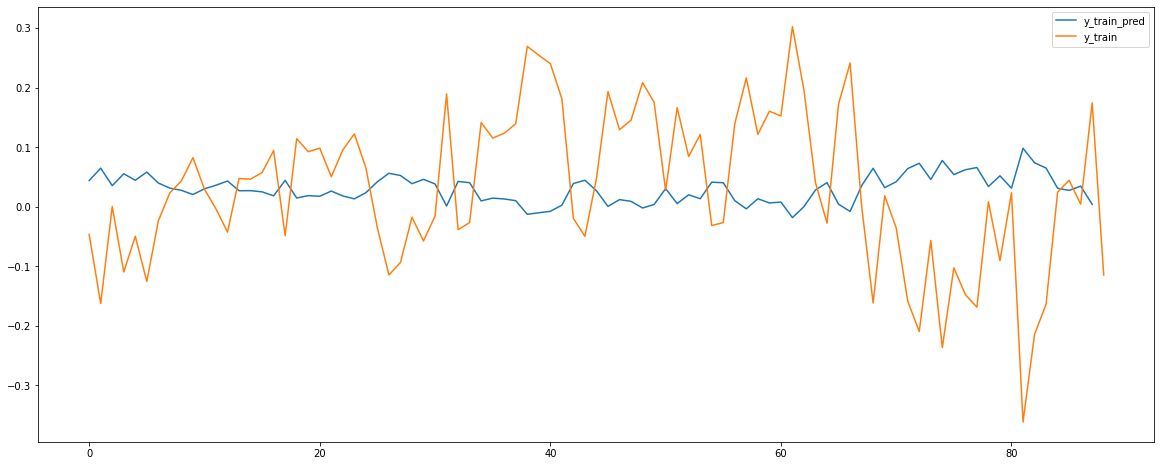

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(y_train_pred[1:] , label ='y_train_pred')
plt.plot(y_train , label ='y_train')
plt.legend(loc='upper right')

In [ ]:
mean_squared_error(y_test_pred , y_test)


0.039130589972744864

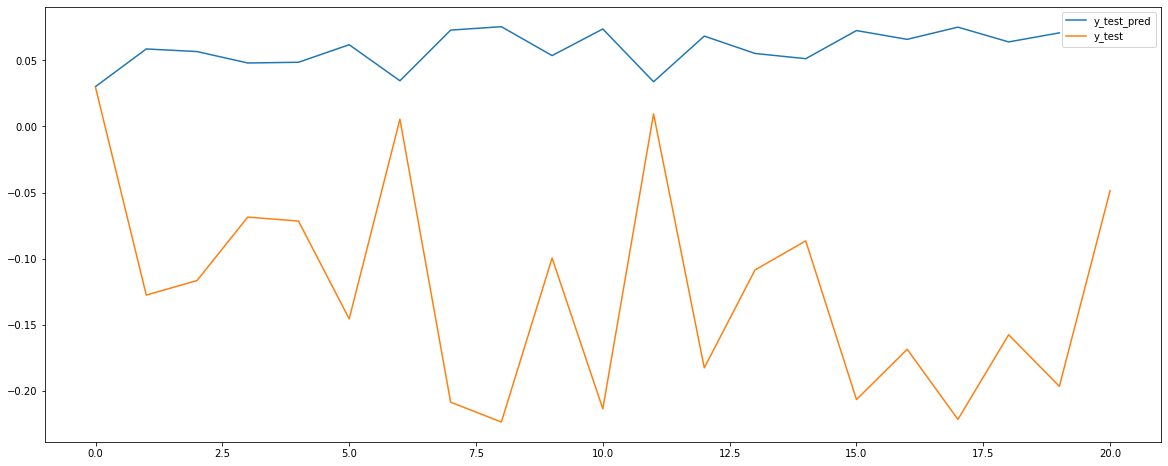

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(y_test_pred[1:],label ='y_test_pred' )
plt.plot(y_test , label ='y_test')
plt.legend(loc='best')

In [ ]:
model = Sequential()
model.add(LSTM(4, input_shape=(X_train.shape[1], X_train.shape[2]))) #input_shape takes time steps and features
#model.add(LSTM(10))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
nb_epoch = 500

model.fit(X_train, y_train, epochs=nb_epoch)

Epoch 1/500
3/3 [==============================] - 2s 6ms/step - loss: 0.0179
Epoch 2/500
3/3 [==============================] - 0s 5ms/step - loss: 0.0176
Epoch 3/500
3/3 [==============================] - 0s 5ms/step - loss: 0.0173
Epoch 4/500
3/3 [==============================] - 0s 5ms/step - loss: 0.0170
Epoch 5/500
3/3 [==============================] - 0s 5ms/step - loss: 0.0169
Epoch 6/500
3/3 [==============================] - 0s 5ms/step - loss: 0.0168
Epoch 7/500
3/3 [==============================] - 0s 5ms/step - loss: 0.0167
Epoch 8/500
3/3 [==============================] - 0s 6ms/step - loss: 0.0166
Epoch 9/500
3/3 [==============================] - 0s 5ms/step - loss: 0.0165
Epoch 10/500
3/3 [==============================] - 0s 7ms/step - loss: 0.0165
Epoch 11/500
3/3 [==============================] - 0s 10ms/step - loss: 0.0164
Epoch 12/500
3/3 [==============================] - 0s 6ms/step - loss: 0.0164
Epoch 13/500
3/3 [==============================] - 0s 5ms/s

In [ ]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

1/1 [==============================] - 0s 24ms/step


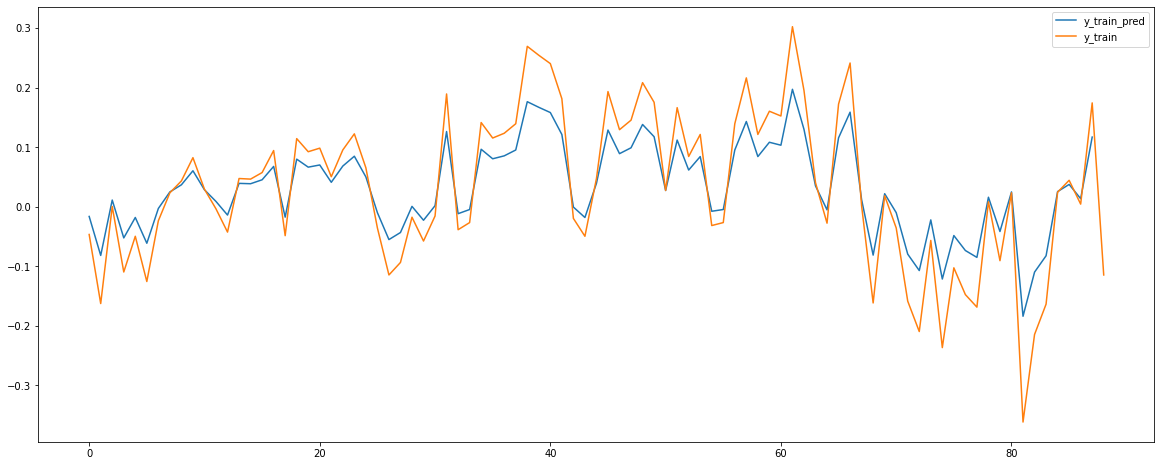

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(y_train_pred[1:] , label ='y_train_pred')
plt.plot(y_train , label ='y_train')
plt.legend(loc='upper right')

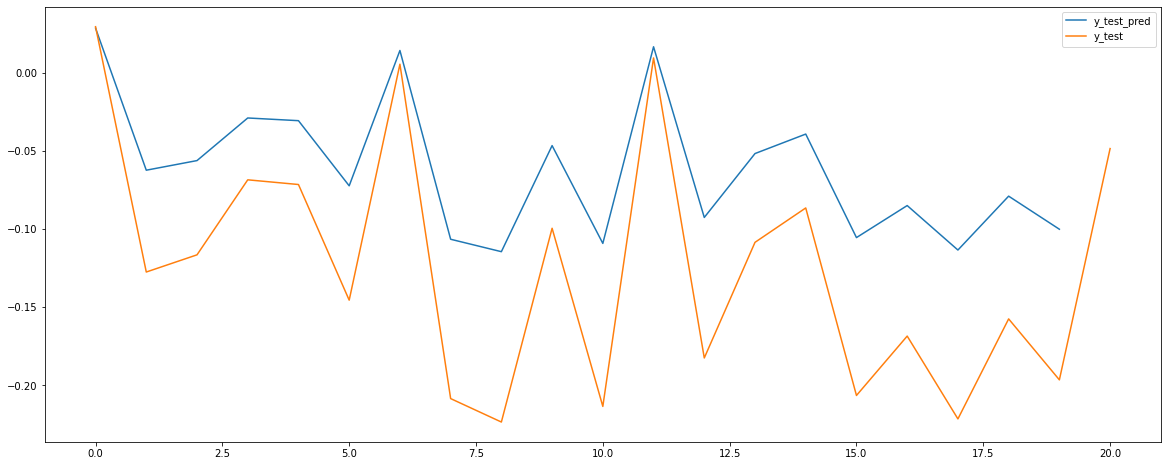

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(y_test_pred[1:],label ='y_test_pred' )
plt.plot(y_test , label ='y_test')
plt.legend(loc='best')

In [ ]:
MaxTempScaledValues = pd.DataFrame(MaxTemp_Rescaled)

df_new = pd.concat([MaxTempScaledValues.shift(10),MaxTempScaledValues.shift(9),
                    MaxTempScaledValues.shift(8),MaxTempScaledValues.shift(7),
                    MaxTempScaledValues.shift(6),MaxTempScaledValues.shift(5),
                   MaxTempScaledValues.shift(4),MaxTempScaledValues.shift(3),
                   MaxTempScaledValues.shift(2),MaxTempScaledValues.shift(1),
                   MaxTempScaledValues],axis=1)
df_new.columns = ['t-10','t-9', 't-8', 't-7' , 't-6' , 't-5' , 't-4', 't-3', 't-2' , 't-1', 't']
df_new = df_new.dropna(how= 'any')
df_new.head(5)

,t-10,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1,t
10,-0.068523,-0.046523,-0.162523,0.000477,-0.109523,-0.049523,-0.125523,-0.023523,0.023477,0.043477,0.082477
11,-0.046523,-0.162523,0.000477,-0.109523,-0.049523,-0.125523,-0.023523,0.023477,0.043477,0.082477,0.029477
12,-0.162523,0.000477,-0.109523,-0.049523,-0.125523,-0.023523,0.023477,0.043477,0.082477,0.029477,-0.003523
13,0.000477,-0.109523,-0.049523,-0.125523,-0.023523,0.023477,0.043477,0.082477,0.029477,-0.003523,-0.042523
14,-0.109523,-0.049523,-0.125523,-0.023523,0.023477,0.043477,0.082477,0.029477,-0.003523,-0.042523,0.047477


In [ ]:
n_points = len(df_new)
train_points = int(2/3*n_points)+1
X2_train, X2_test =df_new.iloc[:train_points , [0 , 1 , 2, 3,4,5,6,7,8,9]], df_new.iloc[train_points :, [0 , 1 , 2, 3,4,5,6,7,8,9]]
y2_train, y2_test =df_new.iloc[:train_points: , 10],  df_new.iloc[train_points: , 10]
print("We have", len(X_train), "training points and", X_test.shape[0], "testing points")

We have 89 training points and 21 testing points


The end...

In [ ]:
from tensorflow.python.framework import ops
ops.reset_default_graph()
keras.backend.clear_session()

X2_train = np.array(X2_train).reshape(X2_train.shape[0], X2_train.shape[1], 1)
X2_test = np.array(X2_test).reshape(X2_test.shape[0], X2_test.shape[1], 1)
print(X2_train.shape)
print(X2_test.shape)

(68, 10, 1)
(33, 10, 1)


In [ ]:
model = Sequential()
model.add(LSTM(units=30, input_shape=(X2_train.shape[1], X2_train.shape[2]))) #input_shape takes time steps and features
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30)                3840      
                                                                 
 dense (Dense)               (None, 1)                 31        
                                                                 
Total params: 3,871
Trainable params: 3,871
Non-trainable params: 0
_________________________________________________________________


In [ ]:
nb_epoch = 500

model.fit(X_train, y_train, epochs=nb_epoch)

Epoch 1/500


ValueError: ignored

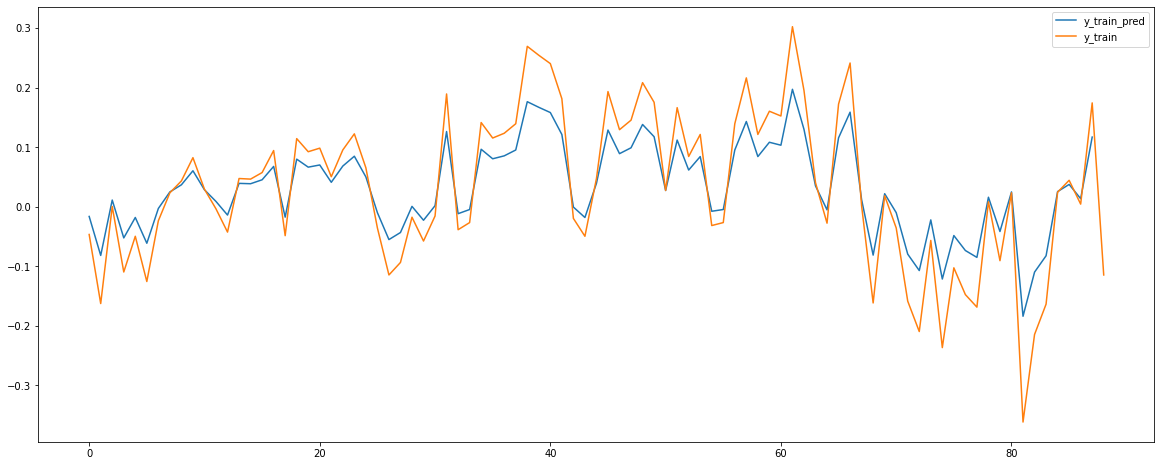

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(y_train_pred[1:] , label ='y_train_pred')
plt.plot(y_train , label ='y_train')
plt.legend(loc='upper right')

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(y_test_pred[1:],label ='y_test_pred' )
plt.plot(y_test , label ='y_test')
plt.legend(loc='best')